albumentations loop: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


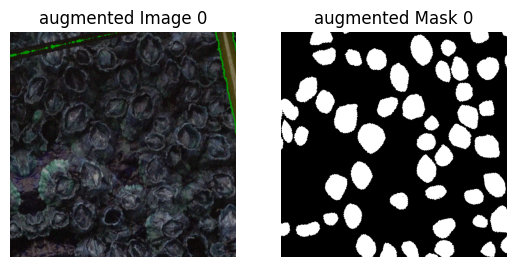

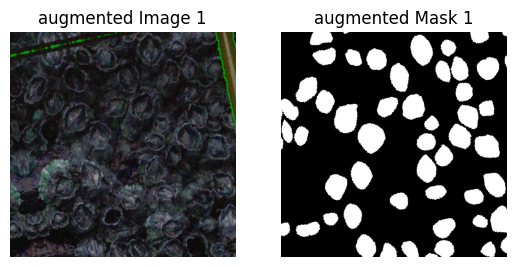

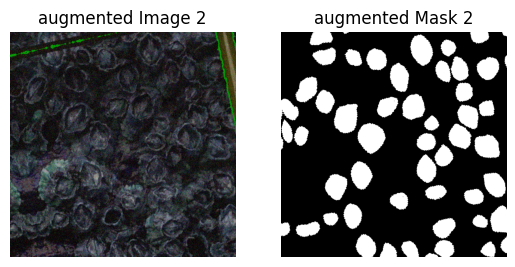

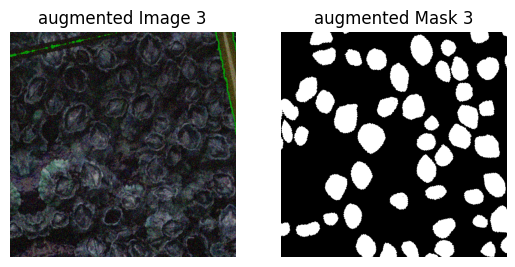

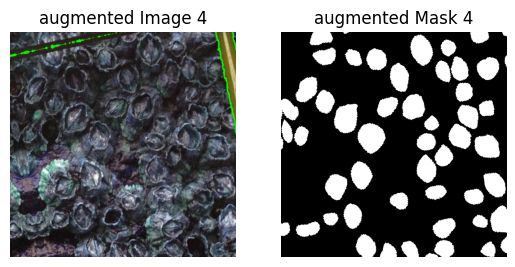

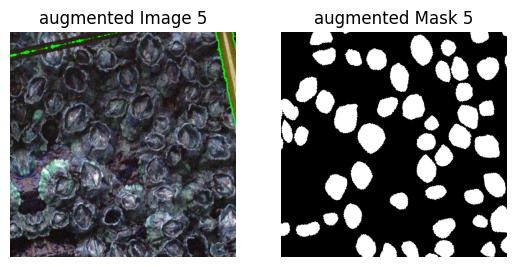

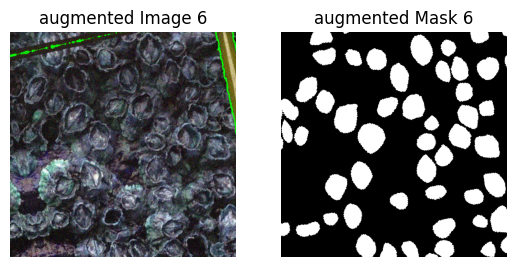

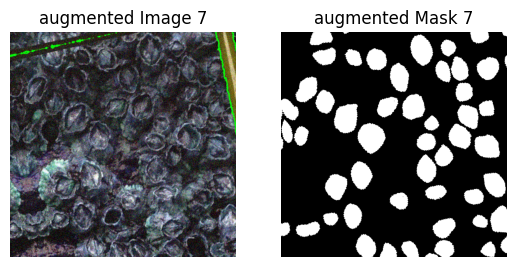

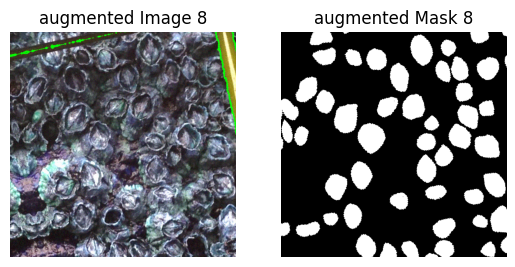

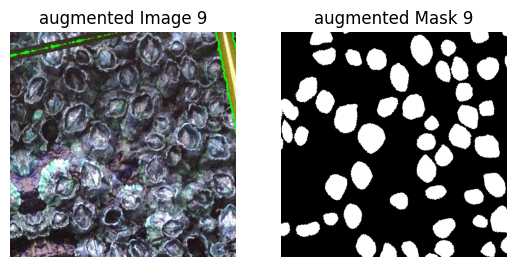

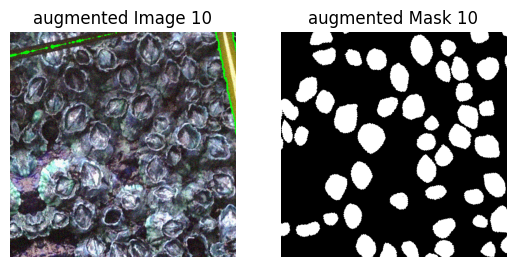

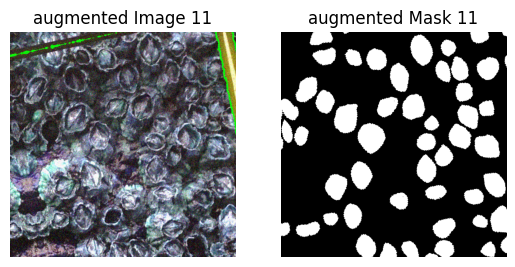

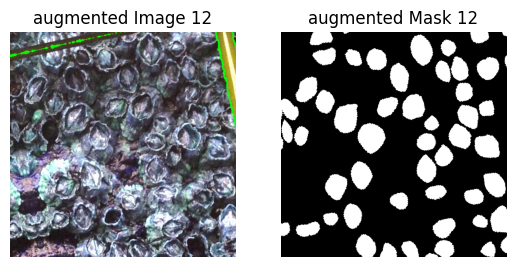

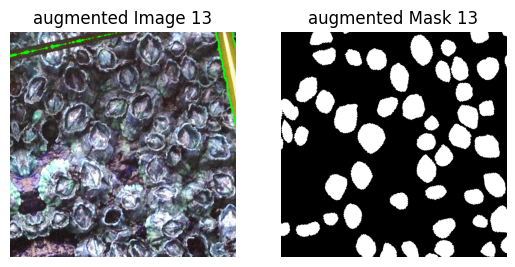

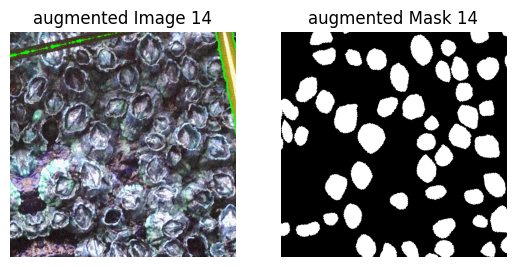

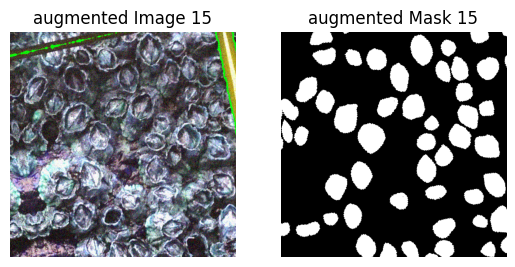

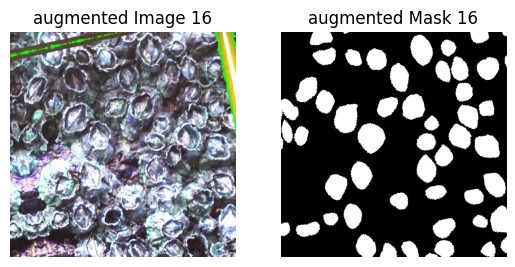

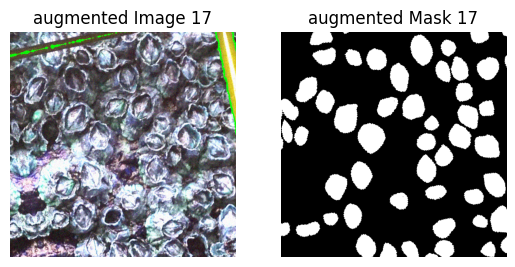

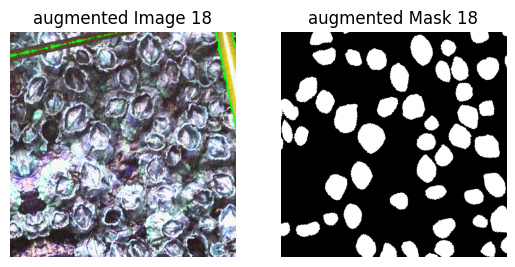

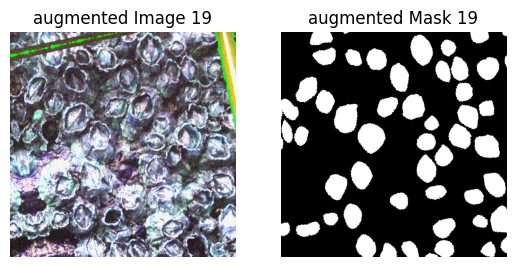

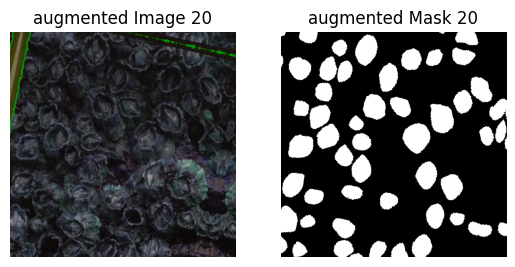

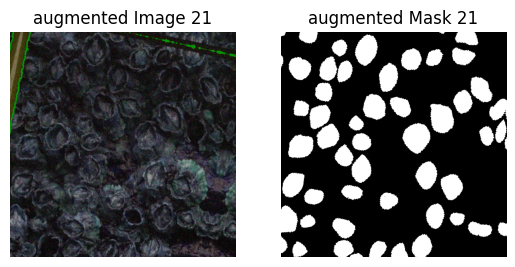

In [ ]:
import cv2 as cv
import numpy as np
import random
from torchvision.transforms import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import import_ipynb
import CropBarnacles
import UNetTrainer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
from tqdm import tqdm
import time
import albumentations as A  
from albumentations.pytorch import ToTensorV2

input_image_path = 'img2.png'
mask_path = 'mask2.png'

# Given input image, crops out unnecessary regions ( which is the area outside of the centroid square )
input_img, x, y, w, h = CropBarnacles.Crop(input_image_path)
# Gives mask_label, consisting of 0s and 1s, while defining min_area
mask_label = UNetTrainer.binaryImg(input_image_path, mask_path, 300)

# Crops the mask to the same dimension location as the input_img
mask_cropped = mask_label[y:y+h, x:x+w]

# Crops input and dimension image to the dimension of the smallest dimension

#dimy= input_img.shape[0] 
#dimx = input_img.shape[1]

dimy = 512
dimx = 513

if dimy > dimx:
    input_img = input_img[:dimx, :dimx]
    mask_cropped = mask_cropped[:dimx, :dimx]
else:
    input_img = input_img[:dimy, :dimy]
    mask_cropped = mask_cropped[:dimy, :dimy]


# Normalize the input_image
input_img = input_img / 255.0  
mask_cropped = np.clip(mask_cropped, 0 , 1)


def flip(image, mask, direction):
    flipped_img = cv.flip(image, direction)
    flipped_mask = cv.flip(mask, direction)
    return flipped_img, flipped_mask

def adjust_brightness(image, mask, factor):
    adjusted_img = np.clip(image * factor, 0, 1) 
    return adjusted_img, mask

def add_gaussian_noise(image, mask, mean=0, std=0.05):
    noise = np.random.normal(mean, std, image.shape)
    noisy_img = np.clip(image + noise, 0, 1)  
    return noisy_img, mask

# Albumentations pipeline for augmentation
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(0.1), contrast_limit=0.3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

augmented_data = []

# Fills augmented data with 10 samples of albumentation augmented data
augmented_data = []

# Apply Albumentations augmentations for ten samples
for _ in tqdm(range(10), desc="albumentations loop"):  
    augmented = augmentations(image=input_img, mask=mask_cropped)
    augmented_img, augmented_mask = augmented['image'], augmented['mask']
    
    # CV augmentations for each albumentation : 10 * 3 * 5 * 4 = 600
    for direction in [-1, 0, 1]:
        flipped_img, flipped_mask = flip(augmented_img, augmented_mask, direction)
        
        for factor in [0.6, 1, 1.4, 1.6, 2]:
            bright_img, bright_mask = adjust_brightness(flipped_img, flipped_mask, factor)
            
            for std in [0.03, 0.05, 0.07, 0.09]:
                noisy_img, noisy_mask = add_gaussian_noise(bright_img, bright_mask, std=std)
                
                augmented_data.append((noisy_img, noisy_mask))

for i, (aug_img, aug_mask) in enumerate(augmented_data):
    plt.subplot(1, 2, 1)
    plt.imshow(aug_img)
    plt.title(f'augmented Image {i}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(aug_mask, cmap='gray')
    plt.title(f'augmented Mask {i}')
    plt.axis('off')
    plt.show()

    if i > 20:
        break




In [116]:
#Imbalanced classes, calculuates ratio of 0s to 1s (background to barnacle pixel)

weight_of_class_1 = 0
aug_img, aug_mask = augmented_data[0]
count0 = (aug_mask == 0).sum().item()
count1 = (aug_mask == 1).sum().item()
# Used later for BCEWithLogitLoss, adjusting loss function with weight ratio
weight_of_class_1 = count0 / count1

total_pixels = torch.numel(torch.tensor(aug_mask))

print(f"Total pixels from original image: {total_pixels}")
print(f"Total pixels from 0 + 1: {count0 + count1}")
print(f"Weight ratio: {weight_of_class_1}")


Total pixels from original image: 262144
Total pixels from 0 + 1: 262144
Weight ratio: 2.5325571366968522


In [122]:
X = []
y = []

transform = transforms.ToTensor()


for i in range(len(augmented_data)):
    inputimg, mask= augmented_data[i]
    tensor_image = transform(inputimg)
    # Changes dimension shape from Channel x Height x Width --> H x W x C
    X.append(tensor_image)
    y.append(mask)

# Array --> np --> tensor

X = np.array(X, dtype='float32')
y = np.array(y, dtype = 'float32')
X = torch.tensor(X,  dtype = torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print("Length X and Y", len(X), len(y))
print("Shape X and Y", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)



dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)
dataloader_train = DataLoader(dataset_train, batch_size=5, shuffle = True)
dataloader_test = DataLoader(dataset_test, batch_size = 5, shuffle = True)

Length X and Y 600 600
Shape X and Y torch.Size([600, 3, 512, 512]) torch.Size([600, 512, 512])


epochs:   3%|▎         | 1/30 [00:40<19:48, 41.00s/it]

Epoch (1/30), Loss: 92.0414


epochs:   7%|▋         | 2/30 [01:14<17:12, 36.88s/it]

Epoch (2/30), Loss: 79.7315


epochs:  10%|█         | 3/30 [01:48<15:59, 35.55s/it]

Epoch (3/30), Loss: 69.0509


epochs:  13%|█▎        | 4/30 [02:25<15:31, 35.82s/it]

Epoch (4/30), Loss: 58.6758


epochs:  17%|█▋        | 5/30 [02:59<14:41, 35.25s/it]

Epoch (5/30), Loss: 45.0752


epochs:  20%|██        | 6/30 [03:34<14:08, 35.35s/it]

Epoch (6/30), Loss: 32.5672


epochs:  23%|██▎       | 7/30 [04:08<13:20, 34.80s/it]

Epoch (7/30), Loss: 24.0852


epochs:  27%|██▋       | 8/30 [04:44<12:51, 35.09s/it]

Epoch (8/30), Loss: 17.7031


epochs:  30%|███       | 9/30 [05:18<12:09, 34.76s/it]

Epoch (9/30), Loss: 13.1556


epochs:  33%|███▎      | 10/30 [05:53<11:35, 34.79s/it]

Epoch (10/30), Loss: 10.9220


epochs:  37%|███▋      | 11/30 [06:27<10:56, 34.53s/it]

Epoch (11/30), Loss: 8.9472


epochs:  40%|████      | 12/30 [07:01<10:21, 34.53s/it]

Epoch (12/30), Loss: 8.3554


epochs:  43%|████▎     | 13/30 [07:35<09:43, 34.30s/it]

Epoch (13/30), Loss: 8.0963


epochs:  47%|████▋     | 14/30 [08:08<09:04, 34.02s/it]

Epoch (14/30), Loss: 7.8730


epochs:  50%|█████     | 15/30 [08:42<08:27, 33.82s/it]

Epoch (15/30), Loss: 7.6710


epochs:  53%|█████▎    | 16/30 [09:17<07:59, 34.27s/it]

Epoch (16/30), Loss: 7.4860


epochs:  57%|█████▋    | 17/30 [14:55<27:13, 125.63s/it]

Epoch (17/30), Loss: 7.2944


epochs:  60%|██████    | 18/30 [15:29<19:36, 98.07s/it] 

Epoch (18/30), Loss: 7.1192


epochs:  63%|██████▎   | 19/30 [16:03<14:27, 78.84s/it]

Epoch (19/30), Loss: 6.9565


epochs:  67%|██████▋   | 20/30 [16:37<10:53, 65.32s/it]

Epoch (20/30), Loss: 6.7917


epochs:  70%|███████   | 21/30 [17:11<08:23, 55.91s/it]

Epoch (21/30), Loss: 6.6445


epochs:  73%|███████▎  | 22/30 [18:39<08:45, 65.65s/it]

Epoch (22/30), Loss: 6.6181


epochs:  77%|███████▋  | 23/30 [19:13<06:32, 56.08s/it]

Epoch (23/30), Loss: 6.6006


epochs:  80%|████████  | 24/30 [19:46<04:55, 49.29s/it]

Epoch (24/30), Loss: 6.5833


epochs:  83%|████████▎ | 25/30 [20:22<03:45, 45.06s/it]

Epoch (25/30), Loss: 6.5668


epochs:  87%|████████▋ | 26/30 [20:57<02:48, 42.04s/it]

Epoch (26/30), Loss: 6.5497


epochs:  90%|█████████ | 27/30 [21:32<02:00, 40.07s/it]

Epoch (27/30), Loss: 6.5328


epochs:  93%|█████████▎| 28/30 [22:06<01:16, 38.20s/it]

Epoch (28/30), Loss: 6.5157


epochs:  97%|█████████▋| 29/30 [22:43<00:37, 37.91s/it]

Epoch (29/30), Loss: 6.4975


epochs: 100%|██████████| 30/30 [23:18<00:00, 46.62s/it]


Epoch (30/30), Loss: 6.4803


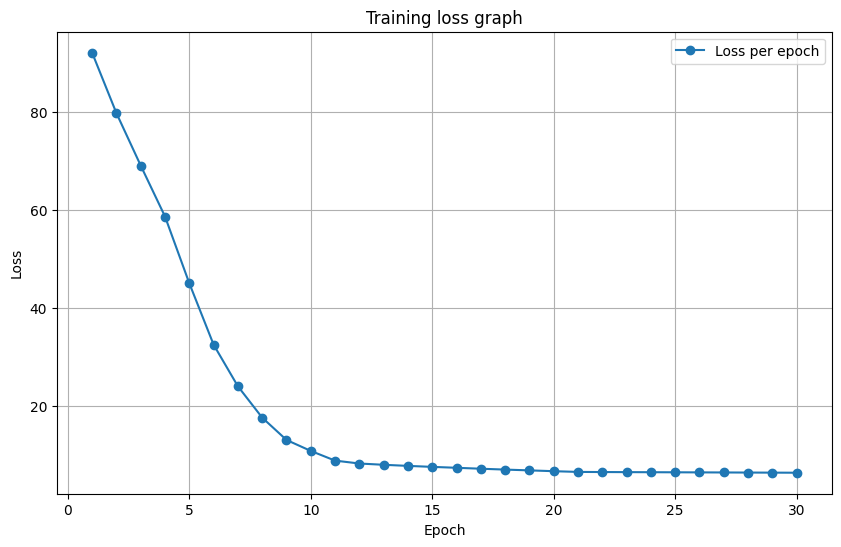

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import relu

class UNet(nn.Module):
    def __init__(self, n_class=1):  
        super().__init__()
        # Custom U-Net architecture

        '''
        Expecting input of 3 x H x W, e.g., 3 x 512 x 512

        Conv2d transforms channels from nn.Conv2d(input_channel_dim, output_channel_dim)
        For example, 3 --> 32 in the first block

        MaxPool2d down-samples H x W by a factor of 2

        ConvTranspose2d up-samples H x W by a factor of 2
        '''
        #Encode
        # 1
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    # -> 32 x H x W
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)       # -> 32 x (H/2) x (W/2)

        # 2
        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # -> 64 x (H/2) x (W/2)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)       # -> 64 x (H/4) x (W/4)

        # 3
        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # -> 128 x (H/4) x (W/4)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)       # -> 128 x (H/8) x (W/8)

        # 4
        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # -> 256 x (H/8) x (W/8)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)       # -> 256 x (H/16) x (W/16)

        # 5
        self.b1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # -> 512 x (H/16) x (W/16)
        self.b2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Decode

        # 4
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # -> 256 x (H/8) x (W/8)
        self.d41 = nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1)      
        self.d42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # 3
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # -> 128 x (H/4) x (W/4)
        self.d31 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)      
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # 2
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # -> 64 x (H/2) x (W/2)
        self.d21 = nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1)         
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # 1
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)   # -> 32 x H x W
        self.d11 = nn.Conv2d(32 + 32, 32, kernel_size=3, padding=1)          
        self.d12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output
        # -> n_class x H x W 
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encode
        # 1
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1  = self.pool1(xe12)

        # 2
        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2  = self.pool2(xe22)

        # 3
        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3  = self.pool3(xe32)

        # 4
        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4  = self.pool4(xe42)

        # 5
        xb1 = relu(self.b1(xp4))
        xb2 = relu(self.b2(xb1))

        # Decode
        # 4
        xu4 = self.upconv4(xb2)  
        # Skip
        xu4 = torch.cat([xu4, xe42], dim=1)  
        xd41 = relu(self.d41(xu4))
        xd42 = relu(self.d42(xd41))

        # 3
        xu3 = self.upconv3(xd42)
        xu3 = torch.cat([xu3, xe32], dim=1)
        xd31 = relu(self.d31(xu3))
        xd32 = relu(self.d32(xd31))

        # 2
        xu2 = self.upconv2(xd32)
        xu2 = torch.cat([xu2, xe22], dim=1)
        xd21 = relu(self.d21(xu2))
        xd22 = relu(self.d22(xd21))

        # 1
        xu1 = self.upconv1(xd22)
        xu1 = torch.cat([xu1, xe12], dim=1)
        xd11 = relu(self.d11(xu1))
        xd12 = relu(self.d12(xd11))

        # Out
        out = self.outconv(xd12)
        return out



# Moves to mps ( Apple version of GPU )
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = UNet(1).to(device)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_of_class_1])).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epoch_losses = []

model = model.to(device)

num_epochs = 30
for epoch in tqdm(range(num_epochs), desc="epochs"):
    model.train()
    epoch_loss = 0.0
    
    for images, masks in tqdm(dataloader_train, desc=f"epoch # {epoch+1}", leave=False):
        images = images.to(device)
        masks = masks.to(device)

        # Removes dimensions of size 1
        
        masks = masks.unsqueeze(1)

        outputs = model(images)   

        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    scheduler.step()
    epoch_losses.append(epoch_loss)
    print(f"Epoch ({epoch + 1}/{num_epochs}), Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss graph')
plt.legend()
plt.grid()
plt.show()


In [124]:
model.eval()

pixel_acc_total = 0
precision_total = 0
recall_total = 0
f1_total = 0
num_batches = 0

weight_ratio_avg = 0
# Performance metrics
with torch.no_grad():
    for images, masks in dataloader_test:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        # Removes dimensions of size 1
        outputs = torch.sigmoid(outputs).squeeze(1)

        # Binary thresholding, setting 1 for vals > 0.5 and 0 for else 
        predictions = (outputs > 0.5).float()

        # Pixel accuracy
        correct = (predictions == masks).float().sum()
        total = torch.numel(masks)
        pixel_acc_total += correct / total

        intersection = (predictions * masks).sum()  

        # Pecision and Recall

        tp = intersection  # TP
        fp = (predictions * (1 - masks)).sum()  # FP
        fn = ((1 - predictions) * masks).sum()  # FN

        precision = tp / (tp + fp)
        recall = tp / (tp + fn )
        precision_total += precision
        recall_total += recall

        #F1 score
        f1_total += 2 * precision * recall / (precision + recall + 1e-6)


        num_batches += 1

        num0 = (predictions == 0).sum().item()
        num1  = (predictions == 1).sum().item()
        weight_ratio_avg += (num0 / num1)


        

weight_ratio_avg = weight_ratio_avg / num_batches
pixel_acc_avg = pixel_acc_total / num_batches
precision_avg = precision_total / num_batches
recall_avg = recall_total / num_batches
f1_avg = f1_total / num_batches

print(f"pixel accuracy: {pixel_acc_avg:0.4f}")
print(f"precision: {precision_avg:0.4f}")
print(f"recall: {recall_avg:0.4f}")
print(f"f1score: {f1_avg:0.4f}")
print(f"Average ratio of 0s to 1s: {weight_ratio_avg:0.4f}")
print(f"Training ratio of 0s to 1s: {weight_of_class_1:0.4f}")

torch.save(model.state_dict(), "unet_model_weights.pth")


pixel accuracy: 0.9768
precision: 0.9383
recall: 0.9793
f1score: 0.9584
Average ratio of 0s to 1s: 2.5178
Training ratio of 0s to 1s: 2.5326


In [158]:
import CropBarnacles
import cv2 as cv
import torch
from torchvision.transforms import ToTensor
from Nearest2n import findClosest
model.load_state_dict(torch.load("unet_model_weights.pth", map_location=device))
model.eval()
model.to(device)

# Given image_path and a specified mininum area, this will return amount of barnacles. 

def BarnacleCounter(image_path, min_area):
    
    
    input_img, x, y, w, h = CropBarnacles.Crop(image_path)
    val = min(w, h)
    nearest2n = findClosest(val)

    # Recropping to size 2n, which is the 2^n closest to min(w, h)
    input_img = input_img[:nearest2n, :nearest2n]

    # Array -> Tensor --> Adds a dimension for batch size(1) so it is N x 3 x H x W
    img_tensor = ToTensor()(input_img).unsqueeze(0).to(device)
    
    # Disables gradient calculation and gets prediction

    with torch.no_grad():
        output = model(img_tensor)

    # Removes singular dimensions, moves to CPU, moves to np, applies binary threshhold

    mask = output.squeeze().cpu().numpy() > 0.5
    
    # 0,1 --> 0, 255


    mask = (mask.astype('uint8') * 255)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    total = 0
    for contour in contours:
        if cv.contourArea(contour) >= min_area:
            total +=1
    return total

image_path = 'img2.png'
print(BarnacleCounter(image_path, 1))


/var/folders/m4/dl9wv7fs6y75t1j0my4jyqjw0000gn/T/ipykernel_8674/1756320140.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_model_w

41
